In [1]:
!pip install jsonlines

In [2]:
import jsonlines
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
sns.set(style="whitegrid")

In [3]:
DATA_DIR = "C:/Users/ashay/Desktop1/cis5300_project/data/scifact/data"
TRAIN_PATH = f"{DATA_DIR}/claims_train.jsonl"
DEV_PATH = f"{DATA_DIR}/claims_dev.jsonl"
TEST_PATH = f"{DATA_DIR}/claims_test.jsonl"
CORPUS_PATH = f"{DATA_DIR}/corpus.jsonl"

print("SciFact Data Explorer")
print(f"Train: {TRAIN_PATH}")
print(f"Dev:   {DEV_PATH}")
print(f"Test:  {TEST_PATH}")

SciFact Data Explorer
Train: C:/Users/ashay/Desktop1/cis5300_project/data/scifact/data/claims_train.jsonl
Dev:   C:/Users/ashay/Desktop1/cis5300_project/data/scifact/data/claims_dev.jsonl
Test:  C:/Users/ashay/Desktop1/cis5300_project/data/scifact/data/claims_test.jsonl


In [4]:
def load_raw_claims(path):
    claims = []
    with jsonlines.open(path) as f:
        for obj in f:
            claims.append(obj)
    return claims

train_raw = load_raw_claims(TRAIN_PATH)
dev_raw = load_raw_claims(DEV_PATH)
test_raw = load_raw_claims(TEST_PATH)

print(f"Train: {len(train_raw)} claims")
print(f"Dev:   {len(dev_raw)} claims")
print(f"Test:  {len(test_raw)} claims")

Train: 809 claims
Dev:   300 claims
Test:  300 claims


In [5]:
corpus_raw = []
with jsonlines.open(CORPUS_PATH) as f:
    for obj in f:
        corpus_raw.append(obj)
print(f"Corpus: {len(corpus_raw)} abstracts")

Corpus: 5183 abstracts



LABEL DISTRIBUTIONS
Train: Counter({'SUPPORT': 332, 'NOT_ENOUGH_INFO': 304, 'CONTRADICT': 173})
Dev:   Counter({'SUPPORT': 124, 'NOT_ENOUGH_INFO': 112, 'CONTRADICT': 64})
Test:  Counter({'NOT_ENOUGH_INFO': 300})

Train:
  SUPPORT             :  332 ( 41.0%)
  CONTRADICT          :  173 ( 21.4%)
  NOT_ENOUGH_INFO     :  304 ( 37.6%)

Dev:
  SUPPORT             :  124 ( 41.3%)
  CONTRADICT          :   64 ( 21.3%)
  NOT_ENOUGH_INFO     :  112 ( 37.3%)

Test:
  SUPPORT             :    0 (  0.0%)
  CONTRADICT          :    0 (  0.0%)
  NOT_ENOUGH_INFO     :  300 (100.0%)


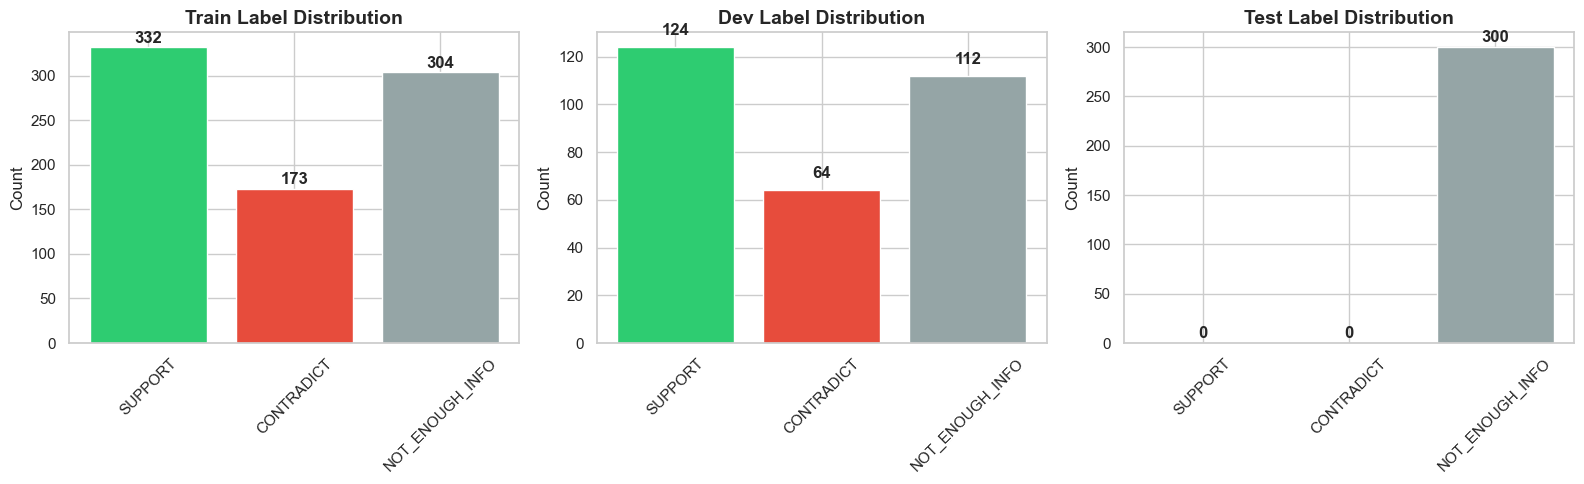

In [6]:
def get_labels_with_inference(claims):
    """
    Extract labels correctly from SciFact format.
    - If 'label' field exists at top level, use it
    - Otherwise, infer from evidence labels
    """
    labels = []
    has_evidence = []
    
    for c in claims:
        raw_label = c.get('label')
        evidence = c.get('evidence', {})
        has_ev = len(evidence) > 0
        
        # CORRECT INFERENCE LOGIC
        if raw_label is not None:
            # Top-level label exists (training data)
            inferred = raw_label
        else:
            # Infer from evidence labels (dev/test data)
            evidence_labels = []
            for doc_id, ev_list in evidence.items():
                for ev_entry in ev_list:
                    evidence_labels.append(ev_entry.get('label'))
            
            # Prioritize: CONTRADICT > SUPPORT > NEI
            if 'CONTRADICT' in evidence_labels:
                inferred = 'CONTRADICT'
            elif 'SUPPORT' in evidence_labels:
                inferred = 'SUPPORT'
            else:
                inferred = 'NOT_ENOUGH_INFO'
        
        labels.append(inferred)
        has_evidence.append(has_ev)
    
    return labels, has_evidence

train_labels, train_has_ev = get_labels_with_inference(train_raw)
dev_labels, dev_has_ev = get_labels_with_inference(dev_raw)
test_labels, test_has_ev = get_labels_with_inference(test_raw)

# Print distributions
print("\n" + "="*60)
print("LABEL DISTRIBUTIONS")
print("="*60)
print(f"Train: {Counter(train_labels)}")
print(f"Dev:   {Counter(dev_labels)}")
print(f"Test:  {Counter(test_labels)}")

# Compute percentages
def print_percentages(labels, split_name):
    counts = Counter(labels)
    total = len(labels)
    print(f"\n{split_name}:")
    for label in ['SUPPORT', 'CONTRADICT', 'NOT_ENOUGH_INFO']:
        count = counts[label]
        pct = (count / total) * 100
        print(f"  {label:20s}: {count:4d} ({pct:5.1f}%)")

print_percentages(train_labels, "Train")
print_percentages(dev_labels, "Dev")
print_percentages(test_labels, "Test")

# Plot
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
label_order = ['SUPPORT', 'CONTRADICT', 'NOT_ENOUGH_INFO']

for ax, labels, title in zip(axes, 
                              [train_labels, dev_labels, test_labels],
                              ['Train', 'Dev', 'Test']):
    counts = Counter(labels)
    ax.bar(label_order, [counts[l] for l in label_order], 
           color=['#2ecc71', '#e74c3c', '#95a5a6'])
    ax.set_title(f"{title} Label Distribution", fontsize=14, fontweight='bold')
    ax.set_ylabel("Count")
    ax.tick_params(axis='x', rotation=45)
    
    # Add count labels on bars
    for i, label in enumerate(label_order):
        count = counts[label]
        ax.text(i, count + 5, str(count), ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig('scifact_label_distribution.png', dpi=150, bbox_inches='tight')
plt.show()


EVIDENCE STATISTICS
Train:
  Total evidence entries: 957
  Avg docs per claim: 1.12
  Avg sentences per evidence: 1.07
  Total evidence sentences: 1025

Dev:
  Total evidence entries: 338
  Avg docs per claim: 1.11
  Avg sentences per evidence: 1.08
  Total evidence sentences: 366

Test:
  Total evidence entries: 0
  Avg docs per claim (with evidence): nan


C:\Users\ashay\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\ashay\anaconda3\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


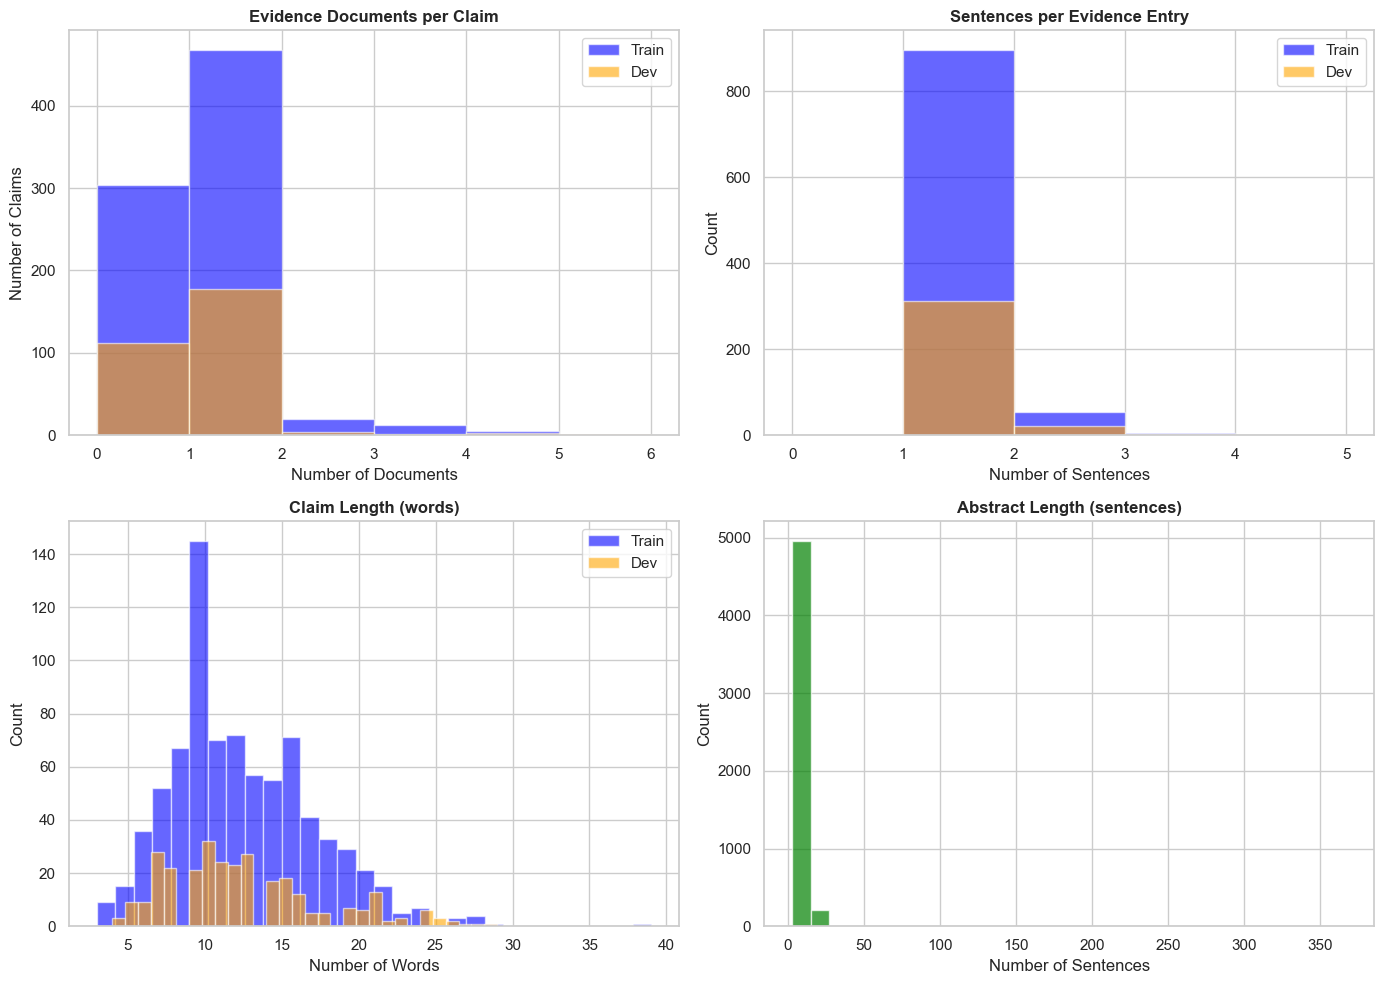

In [7]:
def evidence_stats(claims):
    """Compute evidence statistics."""
    num_docs_per_claim = []
    sentences_per_evidence = []
    total_evidence_entries = 0
    
    for c in claims:
        ev = c.get('evidence', {})
        num_docs_per_claim.append(len(ev))
        
        for doc_id, ev_list in ev.items():
            for ev_entry in ev_list:
                sentences = ev_entry.get('sentences', [])
                sentences_per_evidence.append(len(sentences))
                total_evidence_entries += 1
    
    return num_docs_per_claim, sentences_per_evidence, total_evidence_entries

train_docs, train_sents, train_ev_count = evidence_stats(train_raw)
dev_docs, dev_sents, dev_ev_count = evidence_stats(dev_raw)
test_docs, test_sents, test_ev_count = evidence_stats(test_raw)

print("\n" + "="*60)
print("EVIDENCE STATISTICS")
print("="*60)
print(f"Train:")
print(f"  Total evidence entries: {train_ev_count}")
print(f"  Avg docs per claim: {np.mean([x for x in train_docs if x > 0]):.2f}")
print(f"  Avg sentences per evidence: {np.mean(train_sents):.2f}")
print(f"  Total evidence sentences: {sum(train_sents)}")

print(f"\nDev:")
print(f"  Total evidence entries: {dev_ev_count}")
print(f"  Avg docs per claim: {np.mean([x for x in dev_docs if x > 0]):.2f}")
print(f"  Avg sentences per evidence: {np.mean(dev_sents):.2f}")
print(f"  Total evidence sentences: {sum(dev_sents)}")

print(f"\nTest:")
print(f"  Total evidence entries: {test_ev_count}")
print(f"  Avg docs per claim (with evidence): {np.mean([x for x in test_docs if x > 0]):.2f}")

# Plot evidence distribution
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Docs per claim
axes[0, 0].hist(train_docs, bins=range(0, max(train_docs)+2), alpha=0.6, label='Train', color='blue')
axes[0, 0].hist(dev_docs, bins=range(0, max(dev_docs)+2), alpha=0.6, label='Dev', color='orange')
axes[0, 0].set_title("Evidence Documents per Claim", fontweight='bold')
axes[0, 0].set_xlabel("Number of Documents")
axes[0, 0].set_ylabel("Number of Claims")
axes[0, 0].legend()

# Sentences per evidence
axes[0, 1].hist(train_sents, bins=range(0, max(train_sents)+2), alpha=0.6, label='Train', color='blue')
axes[0, 1].hist(dev_sents, bins=range(0, max(dev_sents)+2), alpha=0.6, label='Dev', color='orange')
axes[0, 1].set_title("Sentences per Evidence Entry", fontweight='bold')
axes[0, 1].set_xlabel("Number of Sentences")
axes[0, 1].set_ylabel("Count")
axes[0, 1].legend()

# Claim length distribution
train_claim_lens = [len(c['claim'].split()) for c in train_raw]
dev_claim_lens = [len(c['claim'].split()) for c in dev_raw]

axes[1, 0].hist(train_claim_lens, bins=30, alpha=0.6, label='Train', color='blue')
axes[1, 0].hist(dev_claim_lens, bins=30, alpha=0.6, label='Dev', color='orange')
axes[1, 0].set_title("Claim Length (words)", fontweight='bold')
axes[1, 0].set_xlabel("Number of Words")
axes[1, 0].set_ylabel("Count")
axes[1, 0].legend()

# Abstract length distribution
abstract_lens = [len(doc['abstract']) for doc in corpus_raw]
axes[1, 1].hist(abstract_lens, bins=30, color='green', alpha=0.7)
axes[1, 1].set_title("Abstract Length (sentences)", fontweight='bold')
axes[1, 1].set_xlabel("Number of Sentences")
axes[1, 1].set_ylabel("Count")

plt.tight_layout()
plt.savefig('scifact_evidence_stats.png', dpi=150, bbox_inches='tight')
plt.show()